# Image recognition
## Task 2.1
---
Task di classificazione di opere d'arte su 18 classi facenti riferimento a movimenti artistici di appartenenza.

### Importazione delle librerie

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from shutil import copyfile
from time import time
import zipfile

from sklearn.metrics import classification_report, confusion_matrix
import keras
from keras.applications import resnet50, densenet
from keras.preprocessing import image as kimage
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Average, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l1, l2
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session

import gc
import tensorflow

Using TensorFlow backend.


### Definizione delle classi da classificare

In [3]:
classes = os.listdir('Pandora_18k')
random.seed(1)
classes.remove('.DS_Store')
classes

['AbstractArt',
 'Baroque',
 'Byzantin_Iconography',
 'Cubism',
 'Early_Renaissance',
 'Expressionism',
 'Fauvism',
 'High_Renaissance',
 'Impressionism',
 'NaiveArt',
 'Northern_Renaissance',
 'PopArt',
 'Post_Impressionism',
 'Realism',
 'Rococo',
 'Romanticism',
 'Surrealism',
 'Symbolism']

## Modello 1: Resnet50_basic

In [4]:
# Training set generator
train_datagen_rb = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
train_generator_rb = train_datagen_rb.flow_from_directory(
        directory='./mask5_train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=128,
        class_mode="categorical",
        shuffle=True,
        seed=1
)

Found 52330 images belonging to 18 classes.


In [5]:
# Validate set generator
val_datagen_rb = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
val_generator_rb = val_datagen_rb.flow_from_directory(
        directory='./mask5_validate',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 17485 images belonging to 18 classes.


In [6]:
# Test set generator
test_datagen_rb = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
test_generator_rb = test_datagen_rb.flow_from_directory(
        directory='./mask5_test',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 17475 images belonging to 18 classes.


### Definzione e training Modello 1

In [7]:
# Download del modello pre-allenato
base_net1 = resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Congelamento dell'80% dei layer interni
limit=int(len(base_net1.layers)*.8)
for layer in base_net1.layers[:limit]:
    layer.trainable = False

# Costruzione layer di specializzazione
x = base_net1.output
pred = Dense(18, activation='softmax')(x)

# Compilazione del modello
resnet_basic = Model(inputs=base_net1.input, outputs=pred)
resnet_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definizione delle callback da utilizzare in fase di allenamento
bestmodel=ModelCheckpoint(filepath='pesi_mask5_resnet_basic.h5', 
                          monitor='val_acc', 
                          verbose=1, 
                          save_best_only=True, 
                          save_weights_only=True, 
                          mode='auto', 
                          period=1)
earlystop=EarlyStopping(monitor='val_acc', 
                        min_delta=0, 
                        patience=6, 
                        verbose=1, 
                        mode='auto', 
                        baseline=None, 
                        restore_best_weights=True)




In [8]:
# Training del modello
resnet_basic.fit_generator(train_generator_rb, steps_per_epoch=len(train_generator_rb), 
                           epochs=50, callbacks=[bestmodel, earlystop], 
                           validation_data=val_generator_rb, 
                           validation_steps=len(val_generator_rb), 
                           verbose=1)


Epoch 1/50
409/409 [==============================] - 579s 1s/step - loss: 1.2827 - acc: 0.5608 - val_loss: 2.2001 - val_acc: 0.3745

Epoch 00001: val_acc improved from -inf to 0.37449, saving model to pesi_mask5_resnet_basic.h5
Epoch 2/50
409/409 [==============================] - 572s 1s/step - loss: 0.7391 - acc: 0.7446 - val_loss: 3.0111 - val_acc: 0.3631

Epoch 00002: val_acc did not improve from 0.37449
Epoch 3/50
409/409 [==============================] - 617s 2s/step - loss: 0.4229 - acc: 0.8569 - val_loss: 2.8564 - val_acc: 0.3899

Epoch 00003: val_acc improved from 0.37449 to 0.38993, saving model to pesi_mask5_resnet_basic.h5
Epoch 4/50
409/409 [==============================] - 659s 2s/step - loss: 0.2207 - acc: 0.9327 - val_loss: 3.0819 - val_acc: 0.4155

Epoch 00004: val_acc improved from 0.38993 to 0.41550, saving model to pesi_mask5_resnet_basic.h5
Epoch 5/50
409/409 [==============================] - 634s 2s/step - loss: 0.1383 - acc: 0.9602 - val_loss: 3.6242 - val_ac

In [8]:
# Shortcut per caricare i pesi prodotti dal training precedente
resnet_basic.load_weights('pesi_mask5_resnet_basic.h5')


### Valutazione Modello 1

In [9]:
# Estrazione true labels e generazione delle predizioni
y_test_rb = test_generator_rb.classes

y_dist_rb = resnet_basic.predict_generator(test_generator_rb, steps=len(test_generator_rb.filenames), verbose=1)
y_pred_rb = np.argmax(y_dist_rb, axis=1)

17475/17475 [==============================] - 265s 15ms/step


In [10]:
# Report
print(classification_report(y_test_rb, y_pred_rb))

              precision    recall  f1-score   support

           0       0.54      0.72      0.61      1110
           1       0.49      0.23      0.31       990
           2       0.79      0.91      0.85       850
           3       0.56      0.74      0.63      1230
           4       0.69      0.55      0.61       750
           5       0.36      0.32      0.34      1030
           6       0.39      0.44      0.41       720
           7       0.61      0.44      0.51       835
           8       0.50      0.35      0.41      1045
           9       0.69      0.38      0.49       940
          10       0.42      0.67      0.51       820
          11       0.85      0.44      0.58      1120
          12       0.31      0.48      0.38      1275
          13       0.29      0.56      0.38      1200
          14       0.49      0.49      0.49       835
          15       0.57      0.06      0.12       895
          16       0.56      0.23      0.33       925
          17       0.36    

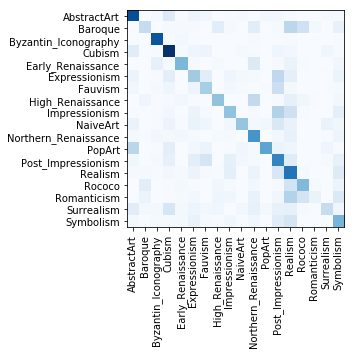

accuracy: 0.474220


In [11]:
# Matrice di confusione
cm = confusion_matrix(y_test_rb, y_pred_rb)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()
print("accuracy: %.6f" % ( cm.trace()/cm.sum() ) )

## Modello 2: Resnet50_plus

In [13]:
# Training set generator
train_datagen_rp = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
train_generator_rp = train_datagen_rp.flow_from_directory(
        directory='./mask5_train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=128,
        class_mode="categorical",
        shuffle=True,
        seed=1
)

Found 52330 images belonging to 18 classes.


In [14]:
# Validate set generator
val_datagen_rp = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
val_generator_rp = val_datagen_rp.flow_from_directory(
        directory='./mask5_validate',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 17485 images belonging to 18 classes.


In [15]:
# Test set generator
test_datagen_rp = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
test_generator_rp = test_datagen_rp.flow_from_directory(
        directory='./mask5_test',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 17475 images belonging to 18 classes.


### Definzione e training Modello 2

In [17]:
# Download del modello pre-allenato
base_net2 = resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Congelamento dell'80% dei layer interni
limit=int(len(base_net2.layers)*.8)
for layer in base_net2.layers[:limit]:
    layer.trainable = False

# Costruzione dei layer di specializzazione
x = base_net2.output
x = Dense(1024, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(512, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
x = Dense(256, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
x = Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
pred = Dense(18, activation='softmax')(x)

# Compilazione del modello
resnet_power = Model(inputs=base_net2.input, outputs=pred)
resnet_power.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definizione delle callback da utilizzare in fase di allenamento
bestmodel=ModelCheckpoint(filepath='pesi_mask5_resnet_power.h5', 
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, save_weights_only=True, 
                          mode='auto', period=1)
earlystop=EarlyStopping(monitor='val_acc', min_delta=0, 
                        patience=6, verbose=1, mode='auto', 
                        baseline=None, restore_best_weights=True)

In [10]:
# Training del modello
resnet_power.fit_generator(train_generator_rp, steps_per_epoch=len(train_generator_rp), 
                           epochs=50, callbacks=[bestmodel, earlystop], 
                           validation_data=val_generator_rp, 
                           validation_steps=len(val_generator_rp), 
                           verbose=1)

Epoch 1/50
409/409 [==============================] - 606s 1s/step - loss: 4.1113 - acc: 0.4201 - val_loss: 3.0186 - val_acc: 0.3086

Epoch 00001: val_acc improved from -inf to 0.30861, saving model to pesi_mask5_resnet_power.h5
Epoch 2/50
409/409 [==============================] - 598s 1s/step - loss: 1.6996 - acc: 0.5338 - val_loss: 2.5795 - val_acc: 0.3973

Epoch 00002: val_acc improved from 0.30861 to 0.39725, saving model to pesi_mask5_resnet_power.h5
Epoch 3/50
409/409 [==============================] - 598s 1s/step - loss: 1.4383 - acc: 0.5978 - val_loss: 3.1658 - val_acc: 0.3338

Epoch 00003: val_acc did not improve from 0.39725
Epoch 4/50
409/409 [==============================] - 598s 1s/step - loss: 1.2427 - acc: 0.6569 - val_loss: 2.5545 - val_acc: 0.3919

Epoch 00004: val_acc did not improve from 0.39725
Epoch 5/50
409/409 [==============================] - 598s 1s/step - loss: 1.0610 - acc: 0.7167 - val_loss: 2.9253 - val_acc: 0.4000

Epoch 00005: val_acc improved from 0.

In [18]:
# Shortcut per caricare i pesi prodotti dal training precedente
resnet_power.load_weights('pesi_mask5_resnet_power.h5')

### Valutazione Modello 2

In [19]:
# Estrazione true labels e generazione delle predizioni
y_test_rp = test_generator_rp.classes

y_dist_rp = resnet_power.predict_generator(test_generator_rp, steps=len(test_generator_rp.filenames), verbose=1)
y_pred_rp = np.argmax(y_dist_rp, axis=1)

17475/17475 [==============================] - 274s 16ms/step


In [20]:
# Report
print(classification_report(y_test_rp, y_pred_rp))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59      1110
           1       0.43      0.32      0.37       990
           2       0.77      0.92      0.84       850
           3       0.49      0.69      0.57      1230
           4       0.50      0.62      0.56       750
           5       0.33      0.29      0.31      1030
           6       0.37      0.42      0.39       720
           7       0.61      0.23      0.33       835
           8       0.48      0.49      0.49      1045
           9       0.54      0.34      0.41       940
          10       0.39      0.57      0.46       820
          11       0.70      0.48      0.57      1120
          12       0.33      0.31      0.32      1275
          13       0.32      0.49      0.39      1200
          14       0.53      0.36      0.43       835
          15       0.37      0.18      0.24       895
          16       0.32      0.30      0.31       925
          17       0.30    

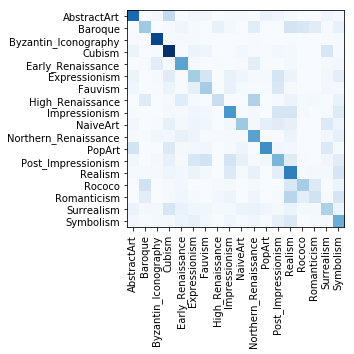

accuracy: 0.449557


In [21]:
# Matrice di confusione
cm = confusion_matrix(y_test_rp, y_pred_rp)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()
print("accuracy: %.6f" % ( cm.trace()/cm.sum() ) )

## Modello 3: Densenet_basic

In [23]:
# Training set generator
train_datagen_db = kimage.ImageDataGenerator(preprocessing_function=densenet.preprocess_input)
train_generator_db = train_datagen_db.flow_from_directory(
        directory='./mask5_train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=128,
        class_mode="categorical",
        shuffle=True,
        seed=1
)

Found 52330 images belonging to 18 classes.


In [24]:
# Validate set generator
val_datagen_db = kimage.ImageDataGenerator(preprocessing_function=densenet.preprocess_input)
val_generator_db = val_datagen_db.flow_from_directory(
        directory='./mask5_validate',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 17485 images belonging to 18 classes.


In [25]:
# Test set generator
test_datagen_db = kimage.ImageDataGenerator(preprocessing_function=densenet.preprocess_input)
test_generator_db = test_datagen_db.flow_from_directory(
        directory='./mask5_test',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 17475 images belonging to 18 classes.


### Definzione e training Modello 3

In [26]:
# Download del modello pre-allenato
base_net3 = densenet.DenseNet201(weights='imagenet', include_top=False, pooling='avg')

# Congelamento dell'80% dei layer interni
limit=int(len(base_net3.layers)*.8)
for layer in base_net3.layers[:limit]:
    layer.trainable = False
    
# Costruzione layer di specializzazione    
x = base_net3.output
pred = Dense(18, activation='softmax')(x)

# Compilazione del modello
densenet_basic = Model(inputs=base_net3.input, outputs=pred)
densenet_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definizione delle callback da utilizzare in fase di allenamento
bestmodel=ModelCheckpoint(filepath='pesi_mask5_densenet_basic.h5', 
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, save_weights_only=True, 
                          mode='auto', period=1)
earlystop=EarlyStopping(monitor='val_acc', min_delta=0, 
                        patience=6, verbose=1, mode='auto', 
                        baseline=None, restore_best_weights=True)



In [19]:
# Training del modello
densenet_basic.fit_generator(train_generator_db, steps_per_epoch=len(train_generator_db), 
                             epochs=50, callbacks=[bestmodel, earlystop], 
                             validation_data=val_generator_db, 
                             validation_steps=len(val_generator_db), 
                             verbose=1)


Epoch 1/50
409/409 [==============================] - 1123s 3s/step - loss: 1.2529 - acc: 0.5702 - val_loss: 3.0813 - val_acc: 0.3715

Epoch 00001: val_acc improved from -inf to 0.37152, saving model to pesi_mask5_densenet_basic.h5
Epoch 2/50
409/409 [==============================] - 1107s 3s/step - loss: 0.6695 - acc: 0.7709 - val_loss: 3.6566 - val_acc: 0.3604

Epoch 00002: val_acc did not improve from 0.37152
Epoch 3/50
409/409 [==============================] - 1107s 3s/step - loss: 0.3323 - acc: 0.8958 - val_loss: 3.8543 - val_acc: 0.3764

Epoch 00003: val_acc improved from 0.37152 to 0.37644, saving model to pesi_mask5_densenet_basic.h5
Epoch 4/50
409/409 [==============================] - 1109s 3s/step - loss: 0.1627 - acc: 0.9560 - val_loss: 4.5094 - val_acc: 0.3858

Epoch 00004: val_acc improved from 0.37644 to 0.38582, saving model to pesi_mask5_densenet_basic.h5
Epoch 5/50
409/409 [==============================] - 1106s 3s/step - loss: 0.0972 - acc: 0.9761 - val_loss: 4.80

In [28]:
# Shortcut per caricare i pesi prodotti dal training precedente
densenet_basic.load_weights('pesi_mask5_densenet_basic.h5')

### Valutazione Modello 3

In [29]:
# Estrazione true labels e generazione delle predizioni
y_test_db = test_generator_db.classes

y_dist_db = densenet_basic.predict_generator(test_generator_db, steps=len(test_generator_db.filenames), verbose=1)
y_pred_db = np.argmax(y_dist_db, axis=1)

17475/17475 [==============================] - 669s 38ms/step


In [30]:
# Report
print(classification_report(y_test_db, y_pred_db))

              precision    recall  f1-score   support

           0       0.75      0.46      0.57      1110
           1       0.62      0.05      0.10       990
           2       0.73      0.89      0.80       850
           3       0.52      0.72      0.60      1230
           4       0.49      0.78      0.60       750
           5       0.32      0.35      0.33      1030
           6       0.29      0.72      0.41       720
           7       0.48      0.51      0.50       835
           8       0.67      0.18      0.28      1045
           9       0.62      0.43      0.51       940
          10       0.53      0.35      0.42       820
          11       0.74      0.50      0.60      1120
          12       0.27      0.22      0.24      1275
          13       0.32      0.51      0.39      1200
          14       0.45      0.60      0.51       835
          15       0.67      0.02      0.04       895
          16       0.38      0.34      0.36       925
          17       0.27    

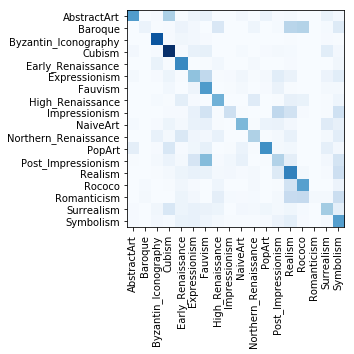

accuracy: 0.443319


In [31]:
# Matrice di confusione
cm = confusion_matrix(y_test_db, y_pred_db)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()
print("accuracy: %.6f" % ( cm.trace()/cm.sum() ) )

## Modello Ensemble

In [34]:
# Retrival e combinazione degli output dei singoli modelli per ogni elemento del test set
# Costruzione dell'output del modello ensemble
y = []
for i in range(len(test_generator_rb)):
    y.append((y_dist_rb[i] + y_dist_rp[i] + y_dist_db[i])/3)

### Valutazione Modello Ensemble

In [35]:
# Estrazione true labels e generazione delle predizioni
y_real = test_generator_db.classes
y_pred = np.argmax(y, axis=1)

# Report
print(classification_report(y_real, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1110
           1       0.58      0.19      0.29       990
           2       0.78      0.93      0.85       850
           3       0.55      0.79      0.65      1230
           4       0.60      0.71      0.65       750
           5       0.41      0.36      0.38      1030
           6       0.38      0.58      0.46       720
           7       0.60      0.45      0.52       835
           8       0.59      0.39      0.47      1045
           9       0.69      0.44      0.53       940
          10       0.48      0.63      0.55       820
          11       0.82      0.51      0.63      1120
          12       0.35      0.38      0.36      1275
          13       0.33      0.61      0.43      1200
          14       0.51      0.58      0.54       835
          15       0.61      0.05      0.09       895
          16       0.48      0.33      0.39       925
          17       0.34    

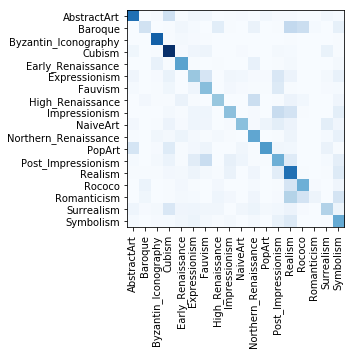

accuracy: 0.505351


In [40]:
# Matrice di confusione
cm = confusion_matrix(y_real, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()
print("accuracy: %.6f" % ( cm.trace()/cm.sum() ) )

## Meta Modello Mask5

I risultati del Modello Ensemble relativi ai singoli chunk sono riaggregati in un meta modello per la classificazione delle immagini originali.

In [41]:
y_pred5 = []
y_true5 = []

for idx in range(0,len(test_generator_rb),5):
    yp5 = np.argmax( sum( y[idx:idx+5] )/5. )
    yt5 = y_real[idx]
    y_pred5.append(yp5)
    y_true5.append(yt5)

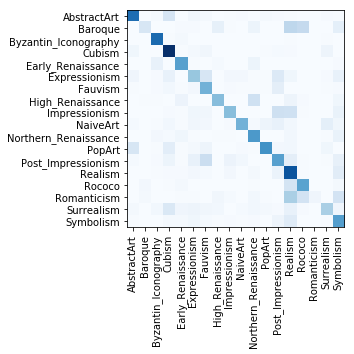

accuracy: 0.577396


In [42]:
# Matrice di confusione 
cm2 = confusion_matrix(y_true5, y_pred5)
plt.imshow(cm2, cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()
print("accuracy: %.6f" % ( cm2.trace()/cm2.sum() ) )

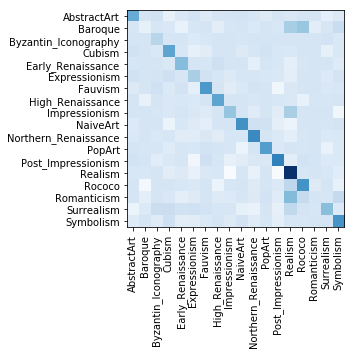

In [47]:
# Matrice di confusione dei miglioramenti
plt.imshow((cm2-cm/5), cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()